# First attempt to pythonise Mike's code and apply it to MERRA2

In [85]:
import sys
import os
import glob
import xarray as xr
import numpy as np
import gc
import logging
import pandas as pd
from math import pi
import matplotlib.pyplot as plt

In [2]:
#relevant directories (move to utils.py eventually)
MERRA2_T2M_U2M_QV2M_dir = '/g/data/rr7/MERRA2/raw/M2T1NXSLV.5.12.4'
MERRA2_SWNETSRF_dir = '/g/data/rr7/MERRA2/raw/M2T1NXINT.5.12.4'
MERRA2_SWGDN_dir = '/g/data/rr7/MERRA2/raw/M2T1NXRAD.5.12.4/'

#### Dask + warning setup

In [3]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)

In [4]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38169,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:44535,Total threads: 1
Dashboard: /proxy/44939/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:46381,


### Step 1 -> Extract daily T, q, Rd, U10 and convert to 7-day running means 
Hourly MERRA2 files are very large - extract only relevant variables for domain of interest with dask and write locally (only need to do this step once)<br>
<sub>Need to write locally as working with dask arrays using .compute crashes the session and takes a long time</sub>

In [5]:
%%time
#load in 2m air temperature (K), 2m eastward wind speed (m/s), 2m specific humidity (kg/kg) and aggregate to daily timescale
T2M_U2M_QV2M_files = []
for year in range(1980,2023):
    for month in range(1,13):
        T2M_U2M_QV2M_files.extend(sorted(glob.glob(f"{MERRA2_T2M_U2M_QV2M_dir}/{year}/{str(month).zfill(2)}/*.nc4")))

def preprocess_T2M_U2M_QV2M(ds): #preprocess function to save memory and time
    logging.getLogger('flox').setLevel(logging.WARNING)
    return ds[['T2M', 'U2M', 'QV2M']].resample(time='1D').mean().sel(lat=slice(-45,-1), lon=slice(100,180))

T2M_U2M_QV2M_cube = xr.open_mfdataset(T2M_U2M_QV2M_files,combine='nested', concat_dim='time',parallel=True, preprocess=preprocess_T2M_U2M_QV2M, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

#write to netcdf and clear up local memory, ok to store locally only takes ~1.5gb
T2M_U2M_QV2M_cube.to_netcdf('/g/data/mn51/users/jb6465/MERRA2_daily_T2M_U2M_QV2M.nc', encoding={'T2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}, 'U2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}, 'QV2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}})
del T2M_U2M_QV2M_cube
gc.collect()

CPU times: user 1h 33min 55s, sys: 6min 2s, total: 1h 39min 58s
Wall time: 2h 15min 1s


15373

In [6]:
%%time
#load in incoming surface solar radiation (W/m2) and aggregate to daily timescale
SWGDN_files = []
for year in range(1980,2023):
    for month in range(1,13):
        SWGDN_files.extend(sorted(glob.glob(f"{MERRA2_SWGDN_dir}/{year}/{str(month).zfill(2)}/*.nc4")))

def preprocess_SWdn(ds): #preprocess function to save memory and time
    logging.getLogger('flox').setLevel(logging.WARNING)
    return ds['SWGDN'].resample(time='1D').mean().sel(lat=slice(-45,-1), lon=slice(100,180))

SWGDN_cube = xr.open_mfdataset(SWGDN_files,combine='nested', concat_dim='time',parallel=True, preprocess=preprocess_SWdn, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

#write to netcdf and clear up local memory, ok to store locally only takes ~500mb
SWGDN_cube.to_netcdf('/g/data/mn51/users/jb6465/MERRA2_daily_SWGDN.nc', encoding={'SWGDN': {'zlib': True, 'complevel': 5, 'dtype':'float32'}})
del SWGDN_cube
gc.collect()

CPU times: user 34min 1s, sys: 1min 54s, total: 35min 56s
Wall time: 46min 33s


13735

<br> 

### Step 2 -> Calculate daily reference ET and convert to 7-day running means

<br>Inputs

In [5]:
T2M_U2M_QV2M_cube = xr.open_dataset('/g/data/mn51/users/jb6465/data/MERRA2_data/MERRA2_daily_T2M_U2M_QV2M.nc')
SWGDN_cube = xr.open_dataset('/g/data/mn51/users/jb6465/data/MERRA2_data/MERRA2_daily_SWGDN.nc')

T2M = T2M_U2M_QV2M_cube['T2M'] #2-m daily mean air temperature [K]
U2M = np.abs(T2M_U2M_QV2M_cube['U2M']) #2-m eastward wind speed [m/s]
QV2M = T2M_U2M_QV2M_cube['QV2M'] #2-m specific humidity [kg/kg]
SWGDN = SWGDN_cube['SWGDN'] #surface downwave shortwave radiation flux [W/m2]

<br>Elevation - following approach from Mike's [MERRA2 paper code](https://www.sciencebase.gov/catalog/item/6515cb7ad34e469cabfcdccd), elev file not stored on gadi so downloaded locally from NASA earthdata

In [6]:
elevfile = xr.open_dataset('/g/data/mn51/users/jb6465/data/MERRA2_data/MERRA2_101.const_2d_asm_Nx.nc4')

geopot = elevfile['PHIS'].sel(lat=slice(-45,-1), lon=slice(100,180))[0]
elev = geopot/9.81 #divide by 9.81m2/s to get elevation [m]

<br>Switch for short crop (0.12m grass) or tall crop (0.50m alfafa)

In [7]:
short_tall_crop_switch = 'short' #short (0.12m grass) or tall (0.50m alfafa)

### Ref ET using [FAO56](https://github.com/jb6465/flash-drought/blob/main/relevant_studies/FAO56.pdf) / Mike fortran code units

<br>Constants

In [208]:
# Cn: numerator crop constant [K.m.s3/(kg.day)]
Cn = 1.6 if short_tall_crop_switch == 'tall' else 0.9 

In [209]:
# Cd: denominator crop constant [s/m]
Cd = 0.38 if short_tall_crop_switch == 'tall' else 0.34

In [210]:
# Gsc: solar constant [J/(m2.hr)]
Gsc = 4.92e6

In [211]:
# sigma: Stefan-Boltzmann constant [J/(K4.m2.day)]
sigma = 4.901e-3

In [212]:
# albedo [unitless]
albedo = 0.23

<br>Input variables

In [213]:
# Rs: downwelling short wave radiation [J/(m2.day)]
Rs = (SWGDN * 86400)

In [214]:
# T: daily mean temperature [°C]
T = T2M-273.15

In [215]:
# Patm: surface pressure [Pa] = f(elev[m])                                                [FAO56 Eq. 7]
Patm = 101300 * ((293. - 0.0065 * elev) / 293.)**5.26

In [216]:
# gamma: psychrometric constant [Pa/°C]                                                   [FAO56 Eq. 8]
gamma = 0.665e-3 * Patm

In [217]:
# esat: saturated vapor pressure [Pa] = f(T[°C])            ,                             [FAO56 Eq. 11]
esat = 610.8 * np.exp((17.27*T/(T+237.3)))

In [218]:
# w: mixing ratio [kg/kg] = f(QV2M[kg/kg])                                                
w = QV2M / (1. - QV2M)

In [219]:
# eact: actual vapor pressure [Pa] = f(Patm[Pa], w[kg/kg])                                [FAO56 Eq. ???]
eact = (Patm * w) / (0.622 + w)
eact = eact.clip(max=esat) #clip eact ≤ esat

In [220]:
# delta: slope of the saturated vapor pressure curve at T [Pa/K] = f(T[°C])               [FAO56 Eq. 13]
delta = (4098. * 610.8 * np.exp(17.27 * T / (T + 237.3))) / (T + 237.3)**2 

In [221]:
# G: ground heat flux  [MJ/(m2.day)], on daily time scales, G ≈ 0                         [FAO56 Eq. 42]
G = 0 

In [222]:
# decl: declination [radians] = f(pi[unitless], jday[unitless])                           [FAO56 Eq. 42]
jday = xr.DataArray(SWGDN.time.dt.dayofyear.values, coords=[('day', SWGDN.time.dt.dayofyear.values)], dims=["day"])
decl = 0.409 * np.sin((2. * np.pi * jday / 365) - 1.39)

In [223]:
# ws: sunset hour angle ws[radians] = f(latitude[rad], dec[rad])                          [FAO56 Eq. 25]
Lat = SWGDN.lat
ws = np.arccos(-1 * np.tan(np.deg2rad(Lat)) * np.tan(decl))

In [224]:
# dr: inverse relative distance of earth from sun [unitless]                              [FAO56 Eq. 23]
dr = 1. + 0.033 * np.cos(2. * np.pi * jday / 365)

In [225]:
# Ra: extra-terrestrial (TOA) SW radiation [J/(m2.day)] = 
#f(Gsc [J/m2/hour], dr [unitless], ws [rad], Lat [rad], decl [rad])                       [FAO56 Eq. 21] 
Ra = (24. / np.pi) * Gsc * dr * (ws * np.sin(np.deg2rad(Lat)) * np.sin(decl) + np.cos(np.deg2rad(Lat)) * np.cos(decl) * np.sin(ws))

In [226]:
# Rso: clear-sky SW radiation at surface [J/m2/day] = f(Ra[J/(m2.day)], elev[m])          [FAO56 Eq. 37]
Rso = Ra * (0.75 + 2e-5 * elev)

In [227]:
# fcd: cloudiness function [unitless]                                                     [FAO56 pg. 79]
RsRso = xr.DataArray((Rs.values)/(Rso.values), coords=[('time', Rs.time.values), ('lat', Rs.lat.values), ('lon', SWGDN.lon.values)], dims=["time", "lat", "lon"])
RsRso = RsRso.clip(min=0.3, max=1.0)
fcd = 1.35 * RsRso - 0.35 
fcd = fcd.clip(min=0.05, max=1.0) #clip values between 0.05 and 1.0

In [228]:
# Rns: Net shortwave radiation  [J/(m2.day)]                                             [FAO56 Eq. 38]
Rns = (1 - albedo) * Rs

In [229]:
# Rnl: net LW radiation upward[J/(m2.day)] = f(sigma [J/(K4.m2.day)], eact[Pa], T[°C])   [FAO56 Eq. 39]
Rnl = sigma * fcd * (0.34 - 0.14 * (0.001 * eact)**0.5) * (T + 273.15)**4.

In [230]:
# Rn: net radiation [J/(m2.day)]
Rn = Rns - Rnl

<br><b>Split ET0 into 3 components: A, B, C</b><br>
From FAO56, Equation 6, PM derivation of ET0
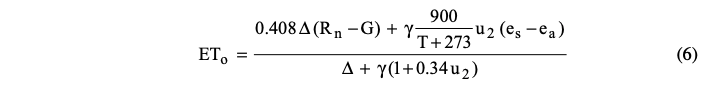

In [237]:
%%time
# A left numerator
A = (0.408*1e-6) * (delta) * (Rn - G)

# B right numerator
B = (gamma) * (Cn/(T+273)) * U2M * ((esat-eact))

# C denominator
C = ((delta) + (gamma) * (1+Cd*U2M))

ET0 = (A+B)/C

CPU times: user 4.95 s, sys: 4.27 s, total: 9.22 s
Wall time: 7.73 s


In [238]:
ET0_xr = xr.DataArray(ET0, dims=['time', 'lat', 'lon'], coords={'time':T.time.values, 'lat': T.lat.values, 'lon': T.lon.values}).rename(f"ET0_{short_tall_crop_switch}_crop")

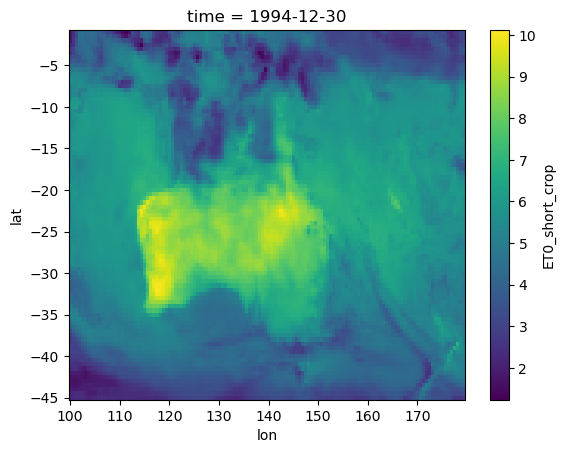

In [239]:
ET0_xr[5477].plot()

<br>

### Step 3 -> Calculate daily sensitivity expressions

In [243]:
ATa = 0.408e-6 * (2.503e6 * np.exp(17.27 * T / (T + 237.3))/ (T + 237.3)**2.) 
ATb = (Rns - (sigma * fcd * (0.34 - 0.14 * (0.001 * (eact))**0.5)* (T + 273.15)**4.))
dATadT = -(2.04245 * np.exp((17.27 * T) / (T + 237.3))* (T**2. * (T + 237.3)**2. - 2049.09 *(T + 237.3)**3 + 474.6 * T * (T + 237.3)**2. + 56311.3 * (T + 237.3)**2.))/ (T + 237.3)**7.
dATbdT = 0.0177088 * fcd * (-76.7982 + (eact)**0.5) * sigma * (T + 273.15)**3.

In [244]:
dAdT = ATa * dATbdT + ATb * dATadT
dAdq = (2.41719e-9 * delta * fcd * Patm * (QV2M - 1.)* sigma * (273.15 + T)**4.)/ ((QV2M - 1.) * ((Patm * QV2M)/ (1.6455 + QV2M))**0.5 * (1.6455 + QV2M)**2.)

In [245]:
dAdR = -0.0352512 * (albedo - 1.) * (delta) + (0.000210686 * (delta) * (-76.7982 + (eact)**0.5) * sigma * (273.15 + T)**4) / Rso.values

In [246]:
B = (0.000665 * 101300. * ((293. - 0.0065 * elev) / 293.)**5.26) * (Cn / (T + 273.15)) * U2M * ((610.8 * np.exp(17.27 * T / (T + 237.3)))- (Patm * (QV2M / (1. - QV2M)) / (0.622 + (QV2M / (1. -QV2M)))))
dBdT = -1.*(67.3431 * Cn * (610.8 * np.exp((17.27 * T) / (237.3 + T)) - (Patm * QV2M) / ((1 - QV2M) * (0.622 + QV2M / (1 - QV2M)))) * U2M) / (273.15 + T)**2. + (41133.2 * Cn * np.exp((17.27 * T) / (237.3 + T)) * (-(17.27 * T) / (237.3 + T)**2. + 17.27 / (237.3 + T)) * U2M) / (273.15 + T)
dBdq = (Cn * Patm * 293.157 * (1 - QV2M) * U2M)/ ((QV2M - 1.) * (1.6455 + QV2M)**2. * (273.15 + T))
dBdU = (0.000665 * Cn * Patm * (610.8 * np.exp((17.27 * T)/(237.3 + T)) - (Patm * w)/(0.622 + w)))/(273.15 + T)

In [247]:
C = 2.503e6 * np.exp(17.27 * T / (T + 237.3)) / (T + 237.3)**2. + 0.000665 * Patm * (1. + Cd * U2M)
dCdT = -(5006000. * np.exp((17.27 * T)/(237.3 + T)) * (-1811.79 + T))/ (237.3 + T)**4.
dCdU = 0.000665 * Cd * Patm

In [248]:
sens_T = (dAdT + dBdT - (A + B) * dCdT / C) / C
sens_R  = dAdR / C
sens_q  = (dAdq + dBdq) / C
sens_U  = ((C * dBdU) - (A + B) * dCdU) / C**2

<br>

### Step 4 -> Case Study / Testing

In [249]:
#function for 7-day rolling, climatology and anomalies
def compute7day_rolling_climo_anom(input_daily_xr): 
    rolling_7d = input_daily_xr.rolling(time=7).mean()
    rolling_7d_climo = rolling_7d.assign_coords(doy=rolling_7d['time'].dt.dayofyear).groupby('doy').mean('time')
    rolling_7d_anom = rolling_7d.groupby('time.dayofyear') - rolling_7d_climo.rename({'doy': 'dayofyear'})
    return rolling_7d, rolling_7d_climo, rolling_7d_anom

In [250]:
#output
ET0_7d, ET0_7d_climo, ET0_7d_anom = compute7day_rolling_climo_anom(ET0_xr)
 
#drivers 7d means
T, T_7d_climo, T_7d_anom = compute7day_rolling_climo_anom(T)
Rs, Rs_7d_climo, Rs_7d_anom = compute7day_rolling_climo_anom(SWGDN)
QV2M, Q_7d_climo, Q_7d_anom = compute7day_rolling_climo_anom(QV2M)
U2M, U2M_7d_climo, U2M_7d_anom = compute7day_rolling_climo_anom(U2M)

In [197]:
ET0_7d_anom.mean(dim=('lat', 'lon')).argmax()

<xarray.DataArray 'ET0_short_crop' ()> Size: 8B
array(1118)

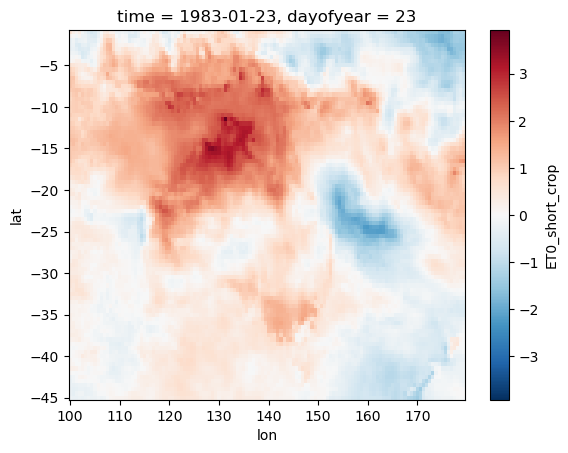

In [253]:
ET0_7d_anom[1118].plot()

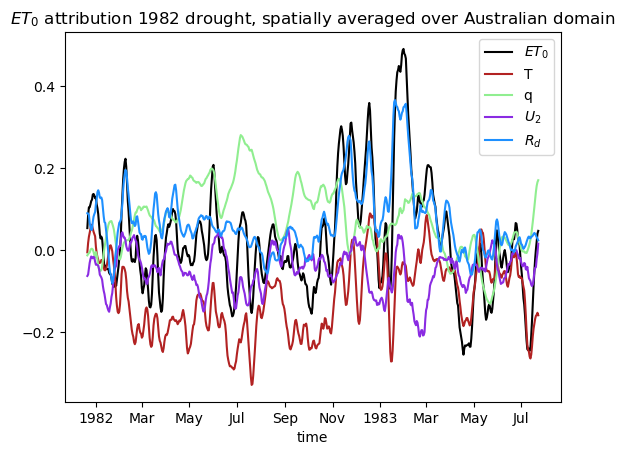

In [281]:
ET0_7d_anom[720:1300].mean(dim=('lat','lon')).plot(color='black', label='$ET_{0}$')
(T_7d_anom[720:1300]*sens_T[720:1300]).mean(dim=('lat','lon')).plot(color='firebrick', label='T')
(Q_7d_anom[720:1300]*sens_q[720:1300]).mean(dim=('lat','lon')).plot(color='lightgreen', label='q')
(U2M_7d_anom[720:1300]*sens_U[720:1300]).mean(dim=('lat','lon')).plot(color='blueviolet', label='$U_{2}$')
(Rs_7d_anom[720:1300]*sens_R[720:1300]).mean(dim=('lat','lon')).plot(color='dodgerblue', label='$R_{d}$')
plt.title('$ET_{0}$ attribution 1982 drought, spatially averaged over Australian domain')
plt.legend()

<br>